## Import Libraries

In [1]:
%matplotlib inline

import os
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import zipfile
import random

from sklearn.model_selection import train_test_split,KFold
from sklearn.utils import check_random_state
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from skimage import exposure
from scipy import ndimage

import nibabel as nib
from nilearn import datasets
from nilearn import plotting

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential, Model

print("TF  Version",tf.__version__)

/usr/local/lib/python3.6/dist-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


TF  Version 2.4.0


## Load Data 


In [2]:
# Define the path + output path:
print(os.getcwd())
DIR = "/tf/notebooks/"
IMG_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
DATA_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
OUTPUT_DIR = "/tf/notebooks/avci/xAI_3D/callbacks/3D_CNN_ONTRAM_stroke_nostroke_datapreprocessed_Loran/"


/tf/notebooks/avci/xAI_3D/usz_notebooks


In [3]:
with h5py.File(IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5', "r") as h5:
    X_in = h5["X"][:]
    Y_img = h5["Y_img"][:]
    Y_pat = h5["Y_pat"][:]
    pat = h5["pat"][:]
    
X_in = np.expand_dims(X_in, axis = 4)
print(X_in.shape, X_in.min(), X_in.max(), X_in.mean(), X_in.std())


(439, 128, 128, 28, 1) -0.7314910890799393 26.423200798592248 -4.100563400421584e-18 1.0


In [4]:
def normalize(volume):
    """Normalize the volume"""
    min = np.min(volume)
    max = np.max(volume) 
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

X_in = np.array([normalize(img) for img in X_in])
print(X_in.shape, X_in.min(), X_in.max(), X_in.mean(), X_in.std())

(439, 128, 128, 28, 1) 0.0 1.0 0.06382954 0.111165084


In [5]:
dat = pd.read_csv('/tf/notebooks/avci/xAI_3D/data/baseline_data_zurich_prepared0.csv', sep=";")

In [6]:
n = []
for p in pat:
    if p in dat.p_id.values:
        n.append(p)
n = len(n)

# match image and tabular data
X = np.zeros((n, X_in.shape[1], X_in.shape[2], X_in.shape[3], X_in.shape[4]))
X_tab = np.zeros((n, 13))
Y_mrs = np.zeros((n))
Y_eventtia = np.zeros((n))
p_id = np.zeros((n))

i = 0
for j, p in enumerate(pat):
    if p in dat.p_id.values:
        k = np.where(dat.p_id.values == p)[0]
        X_tab[i,:] = dat.loc[k,["age", "sexm", "nihss_baseline", "mrs_before",
                               "stroke_beforey", "tia_beforey", "ich_beforey", 
                               "rf_hypertoniay", "rf_diabetesy", "rf_hypercholesterolemiay", 
                               "rf_smokery", "rf_atrial_fibrillationy", "rf_chdy"]]
        X[i] = X_in[j]
        p_id = pat[j]
        Y_eventtia[i] = Y_pat[j]
        Y_mrs[i] = dat.loc[k, "mrs3"]
        i += 1
X_tab.shape

(414, 13)

In [7]:
# Split data into training set and test set

X = np.squeeze(X)
X = np.float32(X)

rng = check_random_state(42)
X_train, X_test, y_train, y_test = train_test_split(X, Y_eventtia, train_size=0.8, random_state=rng)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, train_size=0.5, random_state=rng)

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(331, 128, 128, 28) (42, 128, 128, 28) (41, 128, 128, 28)
(331,) (42,) (41,)


## 3D Data Augmentation

In [8]:
#aumentation functions

@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


@tf.function
def zoom(volume):
    """Rotate the volume by a few degrees"""

    def random_zoom3d(X_im, min_zoom = 0.7 , max_zoom = 1.4):
        z = np.random.sample() *(max_zoom-min_zoom) + min_zoom
        zoom_matrix = np.array([[z, 0, 0, 0],
                            [0, z, 0, 0],
                            [0, 0, z, 0],
                            [0, 0, 0, 1]])
        volume = ndimage.affine_transform(X_im, zoom_matrix, mode = "nearest", order = 1)
        return volume

    augmented_volume = tf.numpy_function(random_zoom3d, [volume], tf.float32)
    return augmented_volume


@tf.function
def gauss(volume):
    """Rotate the volume by a few degrees"""

    def random_gaussianfilter3d(X_im, sigma_max=0.2):
        sigma = np.random.uniform(0, sigma_max)
        volume = ndimage.gaussian_filter(X_im, sigma, mode = "nearest")
        return volume

    augmented_volume = tf.numpy_function(random_gaussianfilter3d, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = zoom(volume)
    volume = gauss(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label



## Model

In [9]:

def stroke_age_3d(input_dim = (128, 128, 28,1)):
    
    initializer = keras.initializers.he_normal(seed = 2202)
    
    #input
    inputs = keras.Input(input_dim)
    x = layers.BatchNormalization()(inputs)
    
    # conv block 0
    x = layers.Convolution3D(16, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Convolution3D(16, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # conv block 1
    x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Convolution3D(32, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # conv block 2
    x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Convolution3D(64, kernel_size=(3, 3, 3), padding = 'same', activation = 'relu', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # conv block 3
    x = layers.Convolution3D(128, kernel_size=(3, 3, 3), padding = 'same',activation = 'relu', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Convolution3D(128, kernel_size=(3, 3, 3), padding = 'same',activation = 'relu', kernel_initializer = initializer)(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    ## conv block 4
    #x = layers.Convolution3D(256, kernel_size=(3, 3, 3), padding = 'same',activation = 'relu', kernel_initializer = initializer)(x)
    #x = layers.BatchNormalization(center=True, scale=True)(x)
    #x = layers.Convolution3D(256, kernel_size=(3, 3, 3), padding = 'same',activation = 'relu', kernel_initializer = initializer)(x)
    #x = layers.BatchNormalization(center=True, scale=True)(x)
    #x = layers.MaxPooling3D(pool_size=(2, 2, 2), padding='same')(x)
    #x = layers.Dropout(0.3)(x)
    
    
    # flat block
    x = layers.GlobalAveragePooling3D()(x) 
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Dense(128, activation = 'relu')(x)
    x = layers.BatchNormalization(center=True, scale=True)(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(units=1, activation = "sigmoid")(x)
    
    # Define the model.
    model_3d = Model(inputs=inputs, outputs=out, name = "cnn_3d_")
    
    return model_3d

# call model
model_3d = stroke_age_3d(input_dim = (128, 128, 28,1))
model_3d.summary()


Model: "cnn_3d_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 28, 1)] 0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 28, 1)   4         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 128, 28, 16)  448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 28, 16)  64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 128, 128, 28, 16)  6928      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 28, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 64, 14, 16)    0   

In [10]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

batch_size = 16

# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(X_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(X_valid))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

#compile
model_3d.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["acc"]
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_cnn_stroke_nostroke_model.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=100)


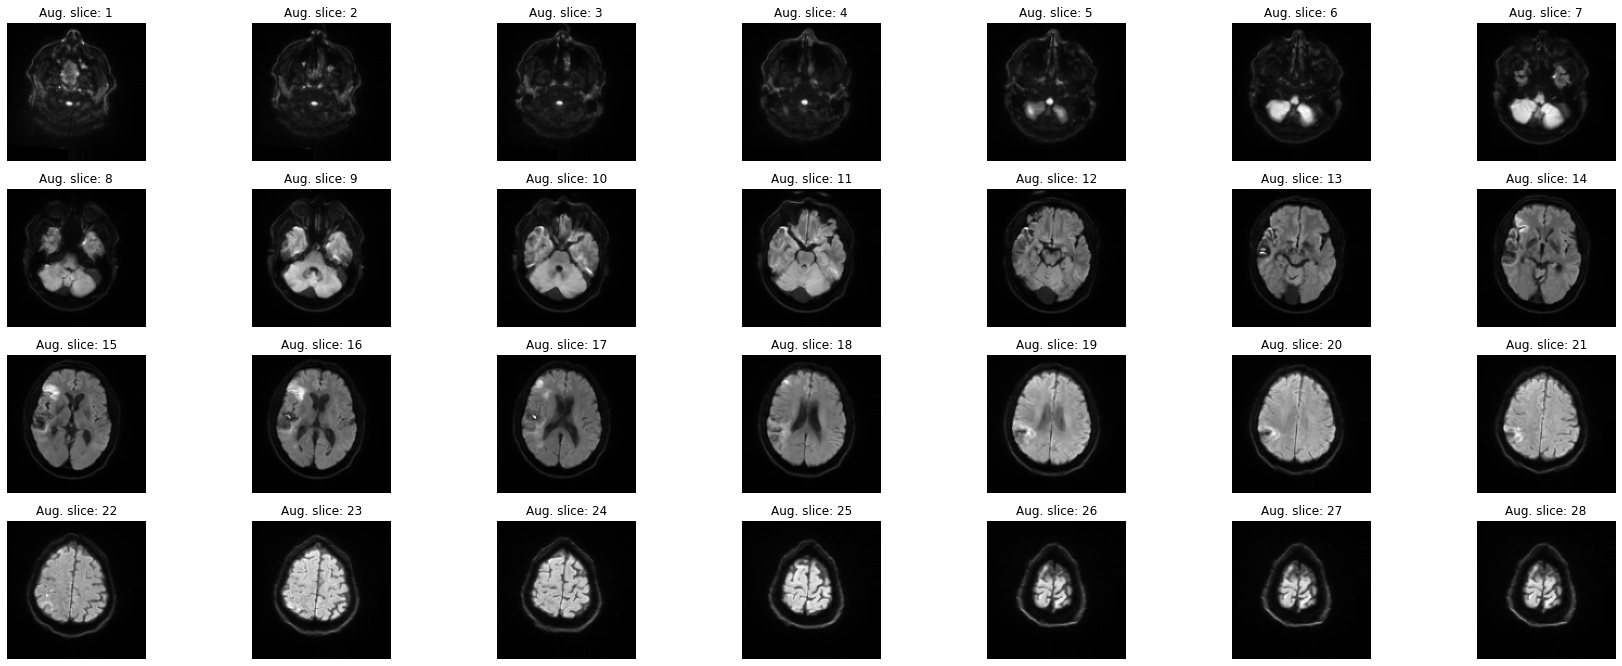

In [11]:
#Visualize Augemntation
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]

plt.figure(figsize=(30,30))
for i in range(image.shape[2]):
    plt.subplot(10,7,i+1)
    plt.imshow(np.squeeze(image[:, :, i]), cmap="gray")
    #plt.imshow(np.squeeze(image[:, i,: ]), cmap="gray")
    plt.axis('off')
    plt.title(str("Aug. slice: " + str(i+1)))
plt.show()
   

In [12]:
# Train the model, doing validation at the end of each epoch
epochs = 250
train= False

if train:
    hist = model_3d.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        shuffle=True,
        verbose=1,
        callbacks=[checkpoint_cb, early_stopping_cb]
)
    
if train:
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label = "loss")
    plt.plot(hist.history['val_loss'],label = "val_loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(hist.history['acc'], label = "acc")
    plt.plot(hist.history['val_acc'],label = "val_acc")
    plt.legend()
    plt.show()
    


## model evaluation

In [13]:
model_3d.load_weights('weights/3d_cnn_stroke_nostroke_model.h5')
model_3d.evaluate(x=X_test, y=y_test)

2/2 [==============================] - 24s 11s/step - loss: 0.3433 - acc: 0.8341


[0.3568330705165863, 0.8292682766914368]

In [15]:
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

def bin_class_report(X_test,y_test, model):
    """
    modified classification report for binary output
    """
    NLL, Acc = model.evaluate( x=X_test, y=y_test, verbose=0)
    y_pred = model.predict(X_test)
    # cm , AUC
    cm = confusion_matrix(np.round(y_test), np.round(y_pred))
    AUC =  metrics.roc_auc_score(np.round(y_test), np.round(y_pred))
    #acc
    nobs = sum(sum(cm))
    count = sum([cm[0,0], cm[1,1]])
    acc_ci_low, acc_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
    #sens 
    sens = cm[1,1]/(cm[1,1]+cm[1,0])
    nobs = sum([cm[1,0],cm[1,1]])
    count = sum([cm[1,1]])
    sens_ci_low, sens_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
    #spec 
    spec = cm[0,0]/(cm[0,1]+cm[0,0])
    nobs = sum([cm[0,1],cm[0,0]])
    count = sum([cm[0,0]])
    spec_ci_low, spec_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
    
    print("\nPerformance on Test Set : ")
    print("\nAccuracy    [95% Conf.] :", np.around(Acc,4),np.around([acc_ci_low, acc_ci_upp],4))
    print("Sensitivity [95% Conf.] :", np.around(sens,4), np.around([sens_ci_low, sens_ci_upp],4))
    print("Specificity [95% Conf.] :", np.around(spec,4), np.around([spec_ci_low, spec_ci_upp],4))
    print("\nArea under Curve (AUC)  :", np.around(AUC,4))
    print("Negative Log-Likelihood :", np.around(NLL, 4))
    #print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis =1)))


model_3d.load_weights('weights/3d_cnn_stroke_nostroke_model.h5')
bin_class_report(X_test, 
                 y_test, 
                 model = model_3d)


Performance on Test Set : 

Accuracy    [95% Conf.] : 0.8293 [0.6874 0.9147]
Sensitivity [95% Conf.] : 0.8667 [0.7032 0.9469]
Specificity [95% Conf.] : 0.7273 [0.4344 0.9025]

Area under Curve (AUC)  : 0.797
Negative Log-Likelihood : 0.3568
